# Distancia productos
Voy a ver de agrupar productos


*  En función de fechas inicio / fin
*  En función de distancia vectorial



## Preparo todo

In [1]:
### me preparo en el entorno
# entorno
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    #FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    #DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    FUENTES_DIR = '/content/drive/MyDrive/MCD/Labo3/FUENTES/' # Ajustar según usuario
    DATOS_DIR = '/content/drive/MyDrive/MCD_grupo17_la_desgracia/lab3/PruebasAK/DATOSL3/' # ajustar según usuario OJO crear un acceso directo para poder "montar" una unidad compartida
else:
    # configuración para notebook con instalación LOCAL
    # FUENTES_DIR = '../FUENTES'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = './DATOS/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Mounted at /content/drive/


In [2]:
## Cargo lo necesario
# Cargo paquetes
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from numpy.polynomial import Polynomial
#from scipy.signal import detrend



#import holidays

#Configuración de parametros de Pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('plotting.backend', 'matplotlib')

In [3]:
!pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 41.5 MB/s eta 0:00:00


In [36]:
from dtaidistance import dtw
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
import time

In [5]:

# ventas al canal, va a ser el archivo padre
#sellin = pd.read_csv(DATOS_DIR +'sell-in.txt', sep='\t')
full_product = pd.read_csv(DATOS_DIR +'df_base_6.csv')
full_product.head()

,periodo,customer_id,product_id,plan_precios_cuidados,tn,dif_tn,dif_por,anio,mes,secuencia,trimestre,date,date_mes,cat1,cat1_cat2,cat1_cat2_cat3,cat1_cat2_cat3_brand,cat1_cat2_cat3_brand_size,stock_final,primera_venta,ultima_venta,alta_cliente,ultima_compra,vive,meses_vida_producto,meses_vida_cliente,meses_vida_prod,ventas_producto_mes,total_mes,rank_producto_mes,share_producto_mes,ventas_cliente_mes,rank_cliente_mes,share_cliente_mes
0,201701,10234,20524,False,0.053,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58667,0.019,21.640,46045,0.064
1,201701,10032,20524,False,0.136,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58668,0.019,299.410,10223,0.879
2,201701,10217,20524,False,0.030,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58669,0.019,18.067,48053,0.053
3,201701,10125,20524,False,0.023,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-11,2020-02,4,4,NaN,6.481,34057.318,58670,0.019,15.985,49651,0.047
4,201701,10012,20524,False,1.545,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58671,0.019,907.775,4779,2.665


## ahora vamos a dejarla solamente como sumarizado por producto por espacio de venta

Vemos que tenemos un cluster muy grande de 560 productos y luego todos clusters chicos de productos con mucho menos cantidad de tiempo

In [6]:

g = full_product.groupby('product_id')['date_mes']
resumen_x = g.agg(primer_mes_venta='min', ultima_mes_venta='max').reset_index()

In [7]:
resumen_x.head()

,product_id,primer_mes_venta,ultima_mes_venta
0,20001,2017-01,2019-12
1,20002,2017-01,2019-12
2,20003,2017-01,2019-12
3,20004,2017-01,2019-12
4,20005,2017-01,2019-12


In [8]:
resumen_x['primer_mes_venta'] = pd.to_datetime(resumen_x['primer_mes_venta'])
resumen_x['ultima_mes_venta'] = pd.to_datetime(resumen_x['ultima_mes_venta'])

resumen_x['periodo_venta'] = (
    resumen_x['primer_mes_venta'].dt.strftime('%Y-%m') +
    ' → ' +
    resumen_x['ultima_mes_venta'].dt.strftime('%Y-%m')
)

In [9]:
conteo = resumen_x['periodo_venta'].value_counts().sort_index()
print(conteo)

periodo_venta
2017-01 → 2017-01      6
2017-01 → 2017-02      3
2017-01 → 2017-03      2
2017-01 → 2017-05      2
2017-01 → 2017-06      7
2017-01 → 2017-07      2
2017-01 → 2017-08      8
2017-01 → 2017-09      9
2017-01 → 2017-10      4
2017-01 → 2017-11      4
2017-01 → 2017-12      2
2017-01 → 2018-01      9
2017-01 → 2018-02      3
2017-01 → 2018-03      8
2017-01 → 2018-04      6
2017-01 → 2018-05     11
2017-01 → 2018-06      6
2017-01 → 2018-07      2
2017-01 → 2018-08      4
2017-01 → 2018-09      1
2017-01 → 2018-10      5
2017-01 → 2018-11      6
2017-01 → 2018-12      2
2017-01 → 2019-01      3
2017-01 → 2019-02     12
2017-01 → 2019-03     12
2017-01 → 2019-04     16
2017-01 → 2019-05     15
2017-01 → 2019-06      8
2017-01 → 2019-07     13
2017-01 → 2019-08      8
2017-01 → 2019-09      9
2017-01 → 2019-10      8
2017-01 → 2019-11      9
2017-01 → 2019-12    560
2017-02 → 2017-08      1
2017-02 → 2017-10      1
2017-02 → 2017-12      1
2017-02 → 2019-12      4
2017-03 → 2

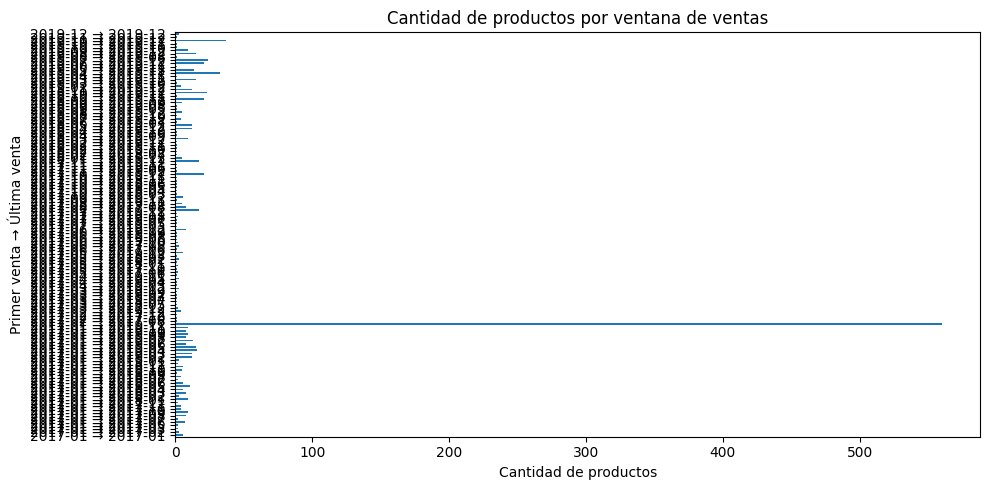

In [10]:
import matplotlib.pyplot as plt

conteo.plot(kind='barh', figsize=(10,5))
plt.xlabel('Cantidad de productos')
plt.ylabel('Primer venta → Última venta')
plt.title('Cantidad de productos por ventana de ventas')
plt.tight_layout()
plt.show()

In [11]:
# Unimos el periodo_venta a la tabla original por producto
full_product = full_product.merge(resumen_x[['product_id', 'periodo_venta']], on='product_id', how='left')
full_product.head()

,periodo,customer_id,product_id,plan_precios_cuidados,tn,dif_tn,dif_por,anio,mes,secuencia,trimestre,date,date_mes,cat1,cat1_cat2,cat1_cat2_cat3,cat1_cat2_cat3_brand,cat1_cat2_cat3_brand_size,stock_final,primera_venta,ultima_venta,alta_cliente,ultima_compra,vive,meses_vida_producto,meses_vida_cliente,meses_vida_prod,ventas_producto_mes,total_mes,rank_producto_mes,share_producto_mes,ventas_cliente_mes,rank_cliente_mes,share_cliente_mes,periodo_venta
0,201701,10234,20524,False,0.053,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58667,0.019,21.640,46045,0.064,2017-01 → 2019-12
1,201701,10032,20524,False,0.136,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58668,0.019,299.410,10223,0.879,2017-01 → 2019-12
2,201701,10217,20524,False,0.030,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58669,0.019,18.067,48053,0.053,2017-01 → 2019-12
3,201701,10125,20524,False,0.023,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-11,2020-02,4,4,NaN,6.481,34057.318,58670,0.019,15.985,49651,0.047,2017-01 → 2019-12
4,201701,10012,20524,False,1.545,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58671,0.019,907.775,4779,2.665,2017-01 → 2019-12


In [28]:
full_product.head()

,periodo,customer_id,product_id,plan_precios_cuidados,tn,dif_tn,dif_por,anio,mes,secuencia,trimestre,date,date_mes,cat1,cat1_cat2,cat1_cat2_cat3,cat1_cat2_cat3_brand,cat1_cat2_cat3_brand_size,stock_final,primera_venta,ultima_venta,alta_cliente,ultima_compra,vive,meses_vida_producto,meses_vida_cliente,meses_vida_prod,ventas_producto_mes,total_mes,rank_producto_mes,share_producto_mes,ventas_cliente_mes,rank_cliente_mes,share_cliente_mes,periodo_venta
0,201701,10234,20524,False,0.053,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58667,0.019,21.640,46045,0.064,2017-01 → 2019-12
1,201701,10032,20524,False,0.136,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58668,0.019,299.410,10223,0.879,2017-01 → 2019-12
2,201701,10217,20524,False,0.030,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58669,0.019,18.067,48053,0.053,2017-01 → 2019-12
3,201701,10125,20524,False,0.023,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-11,2020-02,4,4,NaN,6.481,34057.318,58670,0.019,15.985,49651,0.047,2017-01 → 2019-12
4,201701,10012,20524,False,1.545,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58671,0.019,907.775,4779,2.665,2017-01 → 2019-12


In [29]:
full_product.to_csv(DATOS_DIR +'df_full_product1.csv', index=False)

KeyboardInterrupt: 

In [16]:
full_product.head()

,periodo,customer_id,product_id,plan_precios_cuidados,tn,dif_tn,dif_por,anio,mes,secuencia,trimestre,date,date_mes,cat1,cat1_cat2,cat1_cat2_cat3,cat1_cat2_cat3_brand,cat1_cat2_cat3_brand_size,stock_final,primera_venta,ultima_venta,alta_cliente,ultima_compra,vive,meses_vida_producto,meses_vida_cliente,meses_vida_prod,ventas_producto_mes,total_mes,rank_producto_mes,share_producto_mes,ventas_cliente_mes,rank_cliente_mes,share_cliente_mes,periodo_venta
0,201701,10234,20524,False,0.053,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58667,0.019,21.640,46045,0.064,2017-01 → 2019-12
1,201701,10032,20524,False,0.136,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58668,0.019,299.410,10223,0.879,2017-01 → 2019-12
2,201701,10217,20524,False,0.030,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58669,0.019,18.067,48053,0.053,2017-01 → 2019-12
3,201701,10125,20524,False,0.023,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-11,2020-02,4,4,NaN,6.481,34057.318,58670,0.019,15.985,49651,0.047,2017-01 → 2019-12
4,201701,10012,20524,False,1.545,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58671,0.019,907.775,4779,2.665,2017-01 → 2019-12


In [19]:
# voy a generar los dos df de product_id clusterizados por período de ventas
periodo_objetivo = "2017-01 → 2019-12"
product_ids_ventas_largo = full_product.loc[full_product['periodo_venta'] == periodo_objetivo, ['product_id']].drop_duplicates().reset_index(drop=True)
product_ids_ventas_corto = full_product.loc[full_product['periodo_venta'] != periodo_objetivo, ['product_id']].drop_duplicates().reset_index(drop=True)
print(product_ids_ventas_corto.head(), product_ids_ventas_corto.shape)
print(product_ids_ventas_largo.head(), product_ids_ventas_largo.shape)
product_ids_ventas_corto.to_csv(DATOS_DIR +'product_ids_ventas_corto.csv', index=False)
product_ids_ventas_largo.to_csv(DATOS_DIR +'product_ids_ventas_largo.csv', index=False)

   product_id
0       21151
1       21091
2       21172
3       21287
4       21045 (673, 1)
   product_id
0       20524
1       20311
2       20654
3       21005
4       20974 (560, 1)


## ahora vamos a clusterizar por similitud

### Primero voy a generar la matriz ancha, columna product_id, 36 columnas date, el valor vendido del producto en ese mes en cada columna

In [18]:
full_product.head()

,periodo,customer_id,product_id,plan_precios_cuidados,tn,dif_tn,dif_por,anio,mes,secuencia,trimestre,date,date_mes,cat1,cat1_cat2,cat1_cat2_cat3,cat1_cat2_cat3_brand,cat1_cat2_cat3_brand_size,stock_final,primera_venta,ultima_venta,alta_cliente,ultima_compra,vive,meses_vida_producto,meses_vida_cliente,meses_vida_prod,ventas_producto_mes,total_mes,rank_producto_mes,share_producto_mes,ventas_cliente_mes,rank_cliente_mes,share_cliente_mes,periodo_venta
0,201701,10234,20524,False,0.053,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58667,0.019,21.640,46045,0.064,2017-01 → 2019-12
1,201701,10032,20524,False,0.136,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58668,0.019,299.410,10223,0.879,2017-01 → 2019-12
2,201701,10217,20524,False,0.030,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58669,0.019,18.067,48053,0.053,2017-01 → 2019-12
3,201701,10125,20524,False,0.023,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-11,2020-02,4,4,NaN,6.481,34057.318,58670,0.019,15.985,49651,0.047,2017-01 → 2019-12
4,201701,10012,20524,False,1.545,0.0,0.0,2017,1,1,0,2017-01-01,2017-01,HC,HC_VAJILLA,HC_VAJILLA_Cristalino,HC_VAJILLA_Cristalino_Importado,HC_VAJILLA_Cristalino_Importado_500.0,NaN,2017-01,2019-12,2017-01,2019-12,2020-02,4,4,NaN,6.481,34057.318,58671,0.019,907.775,4779,2.665,2017-01 → 2019-12


In [21]:
#genero tabla ancha
# 1. Agrupamos para sumar ventas del mismo producto/mes
df_agg = full_product.groupby(['product_id', 'date'])['tn'].sum().reset_index()

# 2. Pivot, pasando a formato ancho
df_wide = df_agg.pivot(index='product_id', columns='date', values='tn')
df_wide.head()

date,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01
product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20001,934.772,798.016,1303.358,1069.961,1502.201,1520.065,1030.674,1267.395,1316.946,1439.756,1580.474,1049.389,1169.075,1043.765,1856.835,1251.285,1293.898,1150.792,1470.410,1800.962,1438.675,2295.198,1813.015,1486.687,1275.774,1259.094,1470.657,1647.638,1629.782,1109.938,1678.993,1261.345,1660.006,1561.506,1397.372,1504.689
20002,550.157,505.886,834.735,522.354,843.438,968.158,845.393,619.711,1065.345,857.453,750.419,820.590,984.802,712.001,966.860,999.209,1103.392,1033.828,977.402,1161.884,954.236,1378.490,1766.811,1009.455,1266.788,1043.013,1083.626,1287.623,1034.989,928.364,1066.450,813.782,1090.188,1979.536,1423.577,1087.309
20003,1063.458,752.115,917.165,525.826,620.482,744.088,785.124,864.219,1465.833,1958.598,1426.237,961.663,907.563,788.307,778.556,765.478,784.359,660.733,656.227,955.971,912.342,1313.342,1206.918,769.829,964.769,758.327,638.040,565.338,590.125,662.387,715.203,635.596,967.771,1081.366,948.294,892.501
20004,555.916,508.200,489.913,512.054,543.367,590.508,569.881,1042.530,1259.646,1268.212,897.426,568.797,415.525,503.653,488.925,611.512,641.371,447.845,653.423,936.420,948.863,809.671,802.347,585.565,511.337,441.703,619.771,466.709,603.311,667.194,521.715,482.134,786.171,1064.696,723.942,637.900
20005,494.270,551.431,563.900,662.590,515.587,528.589,625.849,1068.019,1247.889,875.134,776.765,329.429,417.532,399.209,559.987,496.418,637.111,547.625,502.341,874.889,761.775,893.741,469.263,372.634,363.584,409.899,488.214,624.999,897.263,876.397,745.750,536.668,879.528,996.783,606.912,593.244


In [22]:
total_filas = len(df_wide)
sin_nan = (df_wide.isna().sum(axis=1) == 0).sum()
con_nan = total_filas - sin_nan

print(f"Total filas: {total_filas}")
print(f"Filas sin NaN: {sin_nan}")
print(f"Filas con al menos un NaN: {con_nan}")

Total filas: 1233
Filas sin NaN: 536
Filas con al menos un NaN: 697


In [23]:
# OJO esto quiere decir que tengo algunos NaN que en realidad son ceros
def nan_interno_a_cero(row):
    x = row.values.copy()
    # Encuentra el primer valor que no es NaN (arranque de la serie)
    first_idx = np.argmax(~np.isnan(x)) if np.any(~np.isnan(x)) else -1
    # Encuentra el último valor distinto de cero y no NaN
    def is_real(v):
        return not np.isnan(v) and v != 0
    real_idxs = [i for i, v in enumerate(x) if is_real(v)]
    last_idx = max(real_idxs) if real_idxs else -1

    # Sólo procesar si hay algún valor real (no NaN o 0)
    if first_idx == -1 or last_idx == -1:
        return row # devuelvo igual

    for i in range(first_idx, last_idx+1):
        if np.isnan(x[i]):
            x[i] = 0 # reemplazo NaN interno por cero
    return pd.Series(x, index=row.index)

df_corr = df_wide.apply(nan_interno_a_cero, axis=1)
total_filas = len(df_corr)
sin_nan = (df_corr.isna().sum(axis=1) == 0).sum()
con_nan = total_filas - sin_nan

print(f"Total filas: {total_filas}")
print(f"Filas sin NaN: {sin_nan}")
print(f"Filas con al menos un NaN: {con_nan}")

Total filas: 1233
Filas sin NaN: 560
Filas con al menos un NaN: 673


In [24]:
#normailizo y guardo
desvios = df_corr.std(axis=1, skipna=True)
desvios_df = desvios.rename("coef").reset_index()  # DataFrame con columnas: product_id, coef
df_norm = df_corr.div(desvios, axis=0)
df_norm.to_csv(DATOS_DIR +'df_norm.csv', index=False)
desvios_df.to_csv(DATOS_DIR +'desvios_df.csv', index=False)
df_norm.head()


date,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01
product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20001,3.135,2.677,4.372,3.589,5.038,5.098,3.457,4.251,4.417,4.829,5.301,3.520,3.921,3.501,6.228,4.197,4.340,3.860,4.932,6.041,4.825,7.698,6.081,4.986,4.279,4.223,4.933,5.526,5.466,3.723,5.631,4.231,5.568,5.237,4.687,5.047
20002,1.811,1.665,2.747,1.719,2.776,3.186,2.782,2.040,3.506,2.822,2.470,2.701,3.241,2.343,3.182,3.289,3.632,3.403,3.217,3.824,3.141,4.537,5.815,3.322,4.169,3.433,3.566,4.238,3.406,3.055,3.510,2.678,3.588,6.515,4.685,3.579
20003,3.642,2.575,3.141,1.801,2.125,2.548,2.688,2.959,5.019,6.707,4.884,3.293,3.108,2.699,2.666,2.621,2.686,2.263,2.247,3.273,3.124,4.497,4.133,2.636,3.304,2.597,2.185,1.936,2.021,2.268,2.449,2.176,3.314,3.703,3.247,3.056
20004,2.477,2.264,2.183,2.281,2.421,2.631,2.539,4.645,5.612,5.650,3.998,2.534,1.851,2.244,2.178,2.724,2.858,1.995,2.911,4.172,4.228,3.607,3.575,2.609,2.278,1.968,2.761,2.079,2.688,2.973,2.324,2.148,3.503,4.744,3.225,2.842
20005,2.264,2.526,2.583,3.036,2.362,2.422,2.867,4.893,5.717,4.009,3.559,1.509,1.913,1.829,2.566,2.274,2.919,2.509,2.301,4.008,3.490,4.095,2.150,1.707,1.666,1.878,2.237,2.863,4.111,4.015,3.417,2.459,4.029,4.567,2.781,2.718


In [25]:
# genero cluster jerárquicos
# OJO voy a meter 0 en los NaN esto es algo a revisar luego
df_dtw_dist = df_norm
#df_dtw_dist = df_dtw_dist.fillna(0)
df_dtw_dist.head()

date,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01
product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20001,3.135,2.677,4.372,3.589,5.038,5.098,3.457,4.251,4.417,4.829,5.301,3.520,3.921,3.501,6.228,4.197,4.340,3.860,4.932,6.041,4.825,7.698,6.081,4.986,4.279,4.223,4.933,5.526,5.466,3.723,5.631,4.231,5.568,5.237,4.687,5.047
20002,1.811,1.665,2.747,1.719,2.776,3.186,2.782,2.040,3.506,2.822,2.470,2.701,3.241,2.343,3.182,3.289,3.632,3.403,3.217,3.824,3.141,4.537,5.815,3.322,4.169,3.433,3.566,4.238,3.406,3.055,3.510,2.678,3.588,6.515,4.685,3.579
20003,3.642,2.575,3.141,1.801,2.125,2.548,2.688,2.959,5.019,6.707,4.884,3.293,3.108,2.699,2.666,2.621,2.686,2.263,2.247,3.273,3.124,4.497,4.133,2.636,3.304,2.597,2.185,1.936,2.021,2.268,2.449,2.176,3.314,3.703,3.247,3.056
20004,2.477,2.264,2.183,2.281,2.421,2.631,2.539,4.645,5.612,5.650,3.998,2.534,1.851,2.244,2.178,2.724,2.858,1.995,2.911,4.172,4.228,3.607,3.575,2.609,2.278,1.968,2.761,2.079,2.688,2.973,2.324,2.148,3.503,4.744,3.225,2.842
20005,2.264,2.526,2.583,3.036,2.362,2.422,2.867,4.893,5.717,4.009,3.559,1.509,1.913,1.829,2.566,2.274,2.919,2.509,2.301,4.008,3.490,4.095,2.150,1.707,1.666,1.878,2.237,2.863,4.111,4.015,3.417,2.459,4.029,4.567,2.781,2.718


In [26]:
## vamos a ver now dice que puede tomar series cortas, veremos
print("\nCreando la lista de series con su longitud real...")
# Changed dtype to np.double to match expected 'seq_t' type in dtaidistance C code
# Filter out empty series before creating the list
series_list = [row.dropna().to_numpy(dtype=np.double) for index, row in df_norm.iterrows() if not row.dropna().empty]


# Verificamos que se haya creado correctamente
print(f"Tipo de dato creado: {type(series_list)}")
print(f"Número de series en la lista: {len(series_list)}")
print(f"Tipo de dato del primer elemento de la lista: {type(series_list[0])}")
print(f"Longitud de la primera serie: {len(series_list[0])}")
if len(series_list) > 0:
    print(f"Longitud de la última serie (la corta): {len(series_list[-1])}")
else:
    print("No series were created (all were empty).")


Creando la lista de series con su longitud real...
Tipo de dato creado: <class 'list'>
Número de series en la lista: 1213
Tipo de dato del primer elemento de la lista: <class 'numpy.ndarray'>
Longitud de la primera serie: 36
Longitud de la última serie (la corta): 3


In [27]:
series_list

[array([3.13528913, 2.67660021, 4.37154974, 3.58872243, 5.03848463,
        5.09840193, 3.45694987, 4.25092711, 4.41712592, 4.82903757,
        5.30101652, 3.5197202 , 3.92115754, 3.50085726, 6.22795108,
        4.19689308, 4.33982083, 3.85983301, 4.9318547 , 6.04054705,
        4.82541156, 7.6982501 , 6.08097507, 4.98644752, 4.27903047,
        4.22308503, 4.93268128, 5.52629069, 5.46639995, 3.72280594,
        5.63145647, 4.23063725, 5.56777088, 5.23739492, 4.68688106,
        5.04682701]),
 array([1.81071097, 1.66500438, 2.74733215, 1.71920264, 2.77597482,
        3.18646004, 2.78241035, 2.03963045, 3.50633031, 2.82210132,
        2.46982388, 2.70077603, 3.24124016, 2.3433813 , 3.18219088,
        3.28865958, 3.6315517 , 3.40260013, 3.2168872 , 3.82406547,
        3.14063972, 4.5369726 , 5.81503658, 3.32237935, 4.1693294 ,
        3.43283051, 3.56649533, 4.23790597, 3.4064207 , 3.05549003,
        3.50996616, 2.67837014, 3.58809322, 6.51517246, 4.68536595,
        3.57861715]),
 arr

In [39]:
series_list = []
product_ids_list = [] # <-- La lista para guardar los IDs en el orden correcto

for product_id, row in df_norm.iterrows():
    cleaned_series = row.dropna()
    if not cleaned_series.empty:
        series_list.append(cleaned_series.to_numpy(dtype=np.double))
        product_ids_list.append(product_id)

print(f"\nSe procesaron {len(series_list)} series válidas.")
print(f"IDs de productos correspondientes: {product_ids_list}")


Se procesaron 1213 series válidas.
IDs de productos correspondientes: [20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009, 20010, 20011, 20012, 20013, 20014, 20015, 20016, 20017, 20018, 20019, 20020, 20021, 20022, 20023, 20024, 20025, 20026, 20027, 20028, 20029, 20030, 20031, 20032, 20033, 20034, 20035, 20036, 20037, 20038, 20039, 20040, 20041, 20042, 20043, 20044, 20045, 20046, 20047, 20048, 20049, 20050, 20051, 20052, 20053, 20054, 20055, 20056, 20057, 20058, 20059, 20060, 20061, 20062, 20063, 20064, 20065, 20066, 20067, 20068, 20069, 20070, 20071, 20072, 20073, 20074, 20075, 20076, 20077, 20078, 20079, 20080, 20081, 20082, 20083, 20084, 20085, 20086, 20087, 20088, 20089, 20090, 20091, 20092, 20093, 20094, 20095, 20096, 20097, 20098, 20099, 20100, 20101, 20102, 20103, 20104, 20105, 20106, 20107, 20108, 20109, 20110, 20111, 20112, 20113, 20114, 20115, 20116, 20117, 20118, 20119, 20120, 20121, 20122, 20123, 20124, 20125, 20126, 20127, 20128, 20129, 20130, 20131, 20132, 2013

In [30]:
# Esta es la parte computacionalmente más intensiva.
# dtaidistance usará todos los cores de CPU disponibles.
print("\nPaso 3: Calculando la matriz de distancias DTW...")
start_time = time.time()

# La función dtw.distance_matrix_fast es la clave.
# Utiliza una implementación en C con paralelización (OpenMP).
# `use_mp=True` activa el uso de múltiples procesadores.
ds = dtw.distance_matrix_fast(series_list, use_mp=True)

end_time = time.time()
print(f"Cálculo de la matriz de distancias finalizado en {end_time - start_time:.2f} segundos.")
print(f"Dimensiones de la matriz de distancias: {ds.shape}")


Paso 3: Calculando la matriz de distancias DTW...
Cálculo de la matriz de distancias finalizado en 28.29 segundos.
Dimensiones de la matriz de distancias: (1213, 1213)


In [31]:
# ==============================================================================
# 4.5. ¡NUEVO! GUARDAR LA MATRIZ DE DISTANCIAS
# ==============================================================================
print("\nPaso 4.5: Guardando la matriz de distancias en un archivo...")

# Definimos el nombre del archivo
file_path = DATOS_DIR +'dtw_distance_matrix.npy'

# Usamos np.save para guardar el array en formato binario de NumPy
np.save(file_path, ds)

print(f"Matriz guardada exitosamente en '{file_path}'.")
# Comprobamos el tamaño del archivo
#file_size_mb = os.path.getsize(file_path) / (1024 * 1024)
#print(f"Tamaño del archivo: {file_size_mb:.2f} MB")


Paso 4.5: Guardando la matriz de distancias en un archivo...
Matriz guardada exitosamente en '/content/drive/MyDrive/MCD_grupo17_la_desgracia/lab3/PruebasAK/DATOSL3/dtw_distance_matrix.npy'.


In [33]:
# La función `linkage` de Scipy no trabaja con la matriz cuadrada completa,
# sino con una forma "condensada" (un vector con las distancias del triángulo superior).
# `squareform` hace esta conversión por nosotros. Es un paso obligatorio.
condensed_ds = squareform(ds)

print(f"Dimensiones de la matriz de distancias original: {ds.shape}")
print(f"Dimensiones de la matriz de distancias condensada: {condensed_ds.shape}")

Dimensiones de la matriz de distancias original: (1213, 1213)
Dimensiones de la matriz de distancias condensada: (735078,)


In [34]:
# `linkage` es la función que realiza el clustering.
# Parámetros clave:
#   - condensed_ds: Tu matriz de distancias ya preparada.
#   - method='ward': El método de enlace. 'ward' es una excelente opción por defecto.
#     Busca minimizar la varianza dentro de cada cluster. Otras opciones comunes
#     son 'average', 'complete', 'single'.
model = linkage(condensed_ds, method='ward')

print("\nModelo de clustering jerárquico creado.")


Modelo de clustering jerárquico creado.


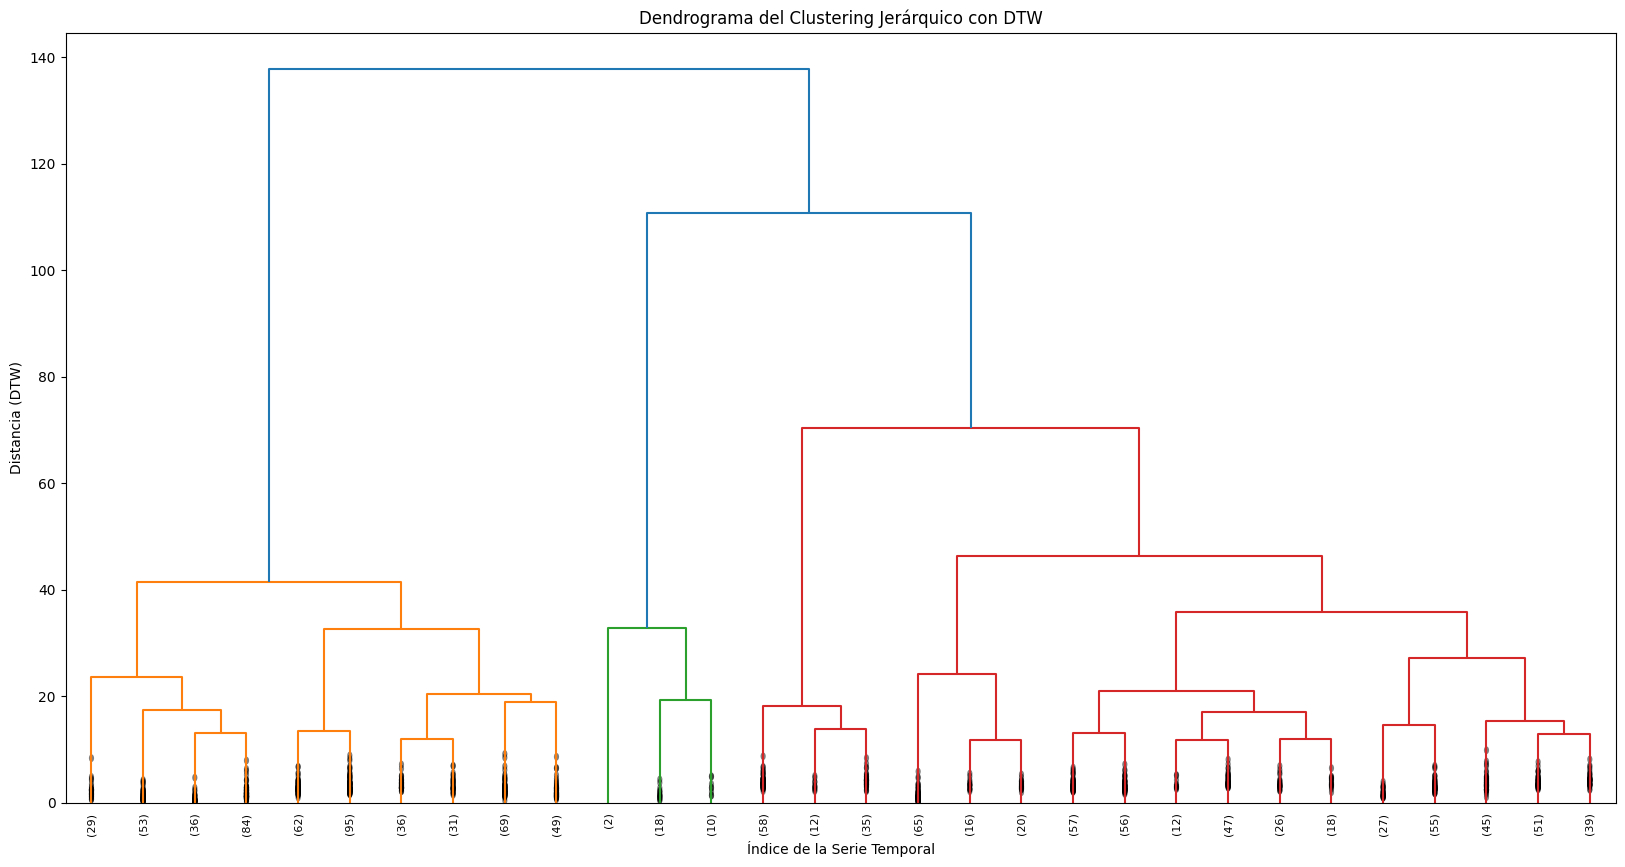

In [35]:
plt.figure(figsize=(20, 10))
plt.title('Dendrograma del Clustering Jerárquico con DTW')
plt.xlabel('Índice de la Serie Temporal')
plt.ylabel('Distancia (DTW)')

# `dendrogram` dibuja el árbol.
# Para datasets grandes (como el tuyo de 1250 series), es imposible etiquetar todo.
# `truncate_mode='lastp'` y `p=30` son tus mejores amigos aquí:
# Muestran los últimos 30 clusters fusionados, que es la parte más importante.
dendrogram(
    model,
    truncate_mode='lastp',  # Muestra solo los últimos 'p' clusters fusionados
    p=30,                   # El número de clusters finales a mostrar
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=True,   # Para representar el tamaño de los clusters no mostrados
)
plt.show()

In [40]:
# ==============================================================================
# 4. EXTRAER LOS CLUSTERS
# ==============================================================================


# Una vez que has visto el dendrograma, puedes "cortarlo" a una altura
# determinada o especificar el número de clusters que quieres.

# Opción A: Especificar el número de clusters (la más común)
# Mirando el dendrograma, decides que quieres, por ejemplo, 5 clusters.
num_clusters = 5
clusters = fcluster(model, t=num_clusters, criterion='maxclust')

# Opción B: Cortar por distancia (útil si tienes una idea de la escala de distancia)
# max_distancia = 20  # Por ejemplo, todos los clusters por debajo de esta distancia se fusionan
# clusters = fcluster(model, t=max_distancia, criterion='distance')

print(f"\nAsignación de clusters para las primeras 20 series (para {num_clusters} clusters):")
# `clusters` es un array donde el valor en la posición `i` es el ID del cluster
# al que pertenece la serie `i`.
for i in range(20):
    print(f"Serie {i} -> Cluster {clusters[i]}")

# Ahora puedes, por ejemplo, añadir esta información a un DataFrame para análisis posterior

df_resultados = pd.DataFrame({
    'product_id': product_ids_list,
    'cluster_id': clusters
})

# Opcional: Establecer 'product_id' como el índice del nuevo DataFrame
df_resultados.set_index('product_id', inplace=True)


print("\nDataFrame de Resultados (product_id -> cluster_id):")
print(df_resultados)

# Puedes verificar la distribución de productos por cluster
print("\nConteo de productos por cluster:")
print(df_resultados['cluster_id'].value_counts())


Asignación de clusters para las primeras 20 series (para 5 clusters):
Serie 0 -> Cluster 3
Serie 1 -> Cluster 4
Serie 2 -> Cluster 5
Serie 3 -> Cluster 5
Serie 4 -> Cluster 5
Serie 5 -> Cluster 3
Serie 6 -> Cluster 5
Serie 7 -> Cluster 5
Serie 8 -> Cluster 3
Serie 9 -> Cluster 1
Serie 10 -> Cluster 5
Serie 11 -> Cluster 5
Serie 12 -> Cluster 3
Serie 13 -> Cluster 5
Serie 14 -> Cluster 3
Serie 15 -> Cluster 5
Serie 16 -> Cluster 5
Serie 17 -> Cluster 5
Serie 18 -> Cluster 5
Serie 19 -> Cluster 5

DataFrame de Resultados (product_id -> cluster_id):
            cluster_id
product_id            
20001                3
20002                4
20003                5
20004                5
20005                5
20006                3
20007                5
20008                5
20009                3
20010                1
20011                5
20012                5
20013                3
20014                5
20015                3
20016                5
20017                5
20018    

In [41]:
# me fijo las ventas de 3, 6,9, 12 meses y valoro los clusters
df_resultados.head()

,cluster_id
product_id,
20001,3
20002,4
20003,5
20004,5
20005,5


In [42]:
# 3lijo y guardo clusters por producto
df_resultados.to_csv(DATOS_DIR +'df_ProdId_cluster_dtw.csv', index=False)